In [1]:
from __future__ import annotations
import numpy as np
from scipy import integrate
from scipy import special
from matplotlib import pyplot as plt
from typing import Optional
import os
from scipy.constants import physical_constants as constants

import torch
from torch import nn
from torch import optim
from tqdm import trange

temperature_unit = 'K'
time_unit = 'fs'
energy_unit = '/cm'

au2fs = 0.02418884254
au2cm = 219474.6305
au2kelvin = 3.1577465e5 

PI = np.pi

In [28]:
# Generate the integration parameters
#scaling = 1.0 / (1000 / au2cm)
scaling = 1
print(scaling)

re = 200 / au2cm * scaling
cutoff = 50 / au2cm * scaling
int_freq_min = (1.0e-7 / au2cm ) * scaling
int_freq_max = (1.0e7 / au2cm) * scaling
int_num = int(1e6)
w = np.logspace(np.log2(int_freq_min), np.log2(int_freq_max), num=int_num, base=2)
#w = np.linspace(0, int_freq_max, num=int_num)

n_pts = 1000
t_learn = (1.0e3 / au2fs) / scaling
t_test = (1.0e3 / au2fs) / scaling
t_min = (1.0e-3 / au2fs) / scaling
# = np.logspace(np.log2(t_min), np.log2(t_learn), num=n_pts, base=2)
#test_domain = np.logspace(np.log2(t_min), np.log2(t_test), num=n_pts, base=2)
learn_domain = np.linspace(0, t_learn, num=n_pts)
test_domain = np.linspace(0, t_test, num=n_pts)
print(t_learn)

1
41341.37457575099


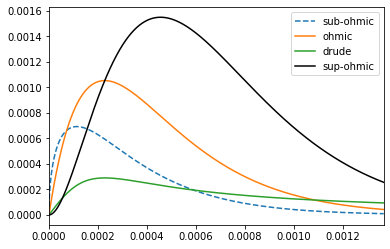

1000


In [32]:

s = 1
wc = cutoff
Lambda = re
def J_w(w,s):
    return (Lambda* np.pi * w**s)/(special.gamma(s)* wc**s) * np.exp(-w/wc)
def D_w(w):
    return (2.0 / np.pi) * Lambda * wc * w / (w**2 + wc**2)

j_1 = J_w(w,s)
j_2 = J_w(w,2)
j_half = J_w(w,0.5)
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.plot(w, j_half, '--', label = 'sub-ohmic') #w * au2cm /scaling
plt.plot(w, j_1, label = 'ohmic') 
plt.plot(w, D_w(w), label = 'drude') 
plt.plot(w, j_2, 'k-', label = 'sup-ohmic') 
#plt.ylim(bottom=0)
#plt.xscale('log')
plt.xlim(0, 300/au2cm)
plt.legend()
plt.show()

print(len(learn_domain))

In [43]:
beta = 1000
def _re(j, w, beta, t):
    # want to integrate over for ever t in the lest
    y = j * np.cos(w * t) / np.tanh(beta * w / 2.0)
    return integrate.simpson(y, x=w)
def _im(j, w, beta, t):
    y = j * np.sin(w * t)
    return -integrate.simpson(y, x=w)
d = j_1
learn_s = np.array([_re(d, w, beta, t_i) for t_i in learn_domain])
learn_a = np.array([_im(d, w, beta, t_i) for t_i in learn_domain])
#test_s = np.array([_re(d, w, beta, t_i) for t_i in test_domain])
#test_a = np.array([_re(jd_1, w, beta, t_i) for t_i in test_domain])

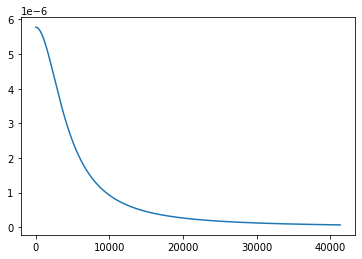

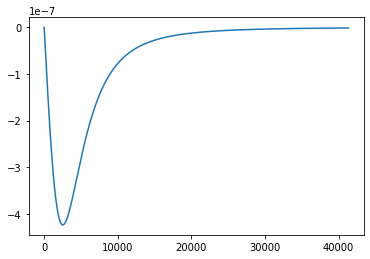

In [44]:
plt.plot(learn_domain, learn_s)
#plt.plot(learn_domain, c_t_r)
#plt.xscale('log')
plt.show()
plt.plot(learn_domain, learn_a)
#plt.xscale('log')
plt.show()



In [45]:
np.savetxt('ohmic_sd.csv', j_half, delimiter=',')
np.savetxt('ohmic_bcf.csv',[learn_s, learn_a], delimiter=',')

In [18]:
beta = 1052.6#c_dt = 0.0
c_t_r = np.zeros_like(learn_domain)
for j in range(len(learn_domain)):
    ans = 0.0
    t = learn_domain[j]
    for i in range(len(w)-1):
        #if i == 0:
            #dw = abs(w[i] - 0)
        #else: 
        dw = abs(w[i+1]-w[i])
        ans += j_half[i] * np.cos(w[i] * t) / np.tanh(beta * w[i] / 2.0)* dw
    #if j %10 ==0:
    #    print(j)
    #print(ans)
    c_t_r[j] = ans
        
    
def c_dt_r(learn_domain):
    #c_t_r = np.zeros_like(learn_domain)
    return np.array([np.sum(j_half * np.cos(w * t) / np.tanh(beta * w / 2.0)* dw) for t in learn_domain])
#c_t_r = c_dt_r(learn_domain)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [5]:
def gen_target_func(beta):
    ph_parameters = []
    bsds = [sd.function for sd in sds]
    w = np.logspace(np.log2(int_freq_min), np.log2(int_freq_max), num=int_num, base=2)

    def _re(t):
        def _re_i(t_i):
            ans = 0.0
            for omega, g in ph_parameters:
                ans += (g**2) * np.cos(omega * t_i) / np.tanh(beta * omega / 2.0)
            for bsd in bsds:
                f = bsd(w) * np.cos(w * t_i) / np.tanh(beta * w / 2.0)
                ans += integrate.simpson(f, w)
            return ans
        return np.array([_re_i(t_i) for t_i in t])

    def _im(t):
        def _im_i(t_i):
            ans = 0.0
            for omega, g in ph_parameters:
                ans -= (g**2) * np.sin(omega * t_i)
            for bsd in bsds:
                f = bsd(w) * np.sin(w * t_i)
                ans -= integrate.simpson(f, w)
            return ans
        return np.array([_im_i(t_i) for t_i in t])

    return _re, _im

In [6]:
beta = 1052.6#1/(300) * constants["kelvin-hartree relationship"][0]
print(beta)
re, im = gen_target_func(beta = beta)
learn_s = re(learn_domain)
test_s = re(test_domain)
learn_a = im(learn_domain)
test_a = im(test_domain)

1052.6


NameError: name 'sds' is not defined